$$
\begin{align}
\frac{\partial P_i}{\partial t} &= \mu_{ref} \cdot T_f \cdot \left(1 - \exp\left(\frac{-\alpha_i^{Chl} \theta_i^C I}{\mu_{ref} T_f V_i}\right)\right) \cdot V_i \cdot P_i - g_z^{\max} \cdot Z \cdot \frac{P_i}{K_{P_i} + P_i} - m_i \cdot T_f \cdot P_i - \alpha_i \cdot P_i^{1.75} \\
\frac{\partial P_i}{\partial t} &= f(\theta)
\end{align}
$$

In [1]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint_adjoint as odeint
import pandas as pd
import numpy as np
import xarray as xr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
# Neuromancer imports (symbolic API)
import neuromancer as nm
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss
from neuromancer.trainer import Trainer
from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer import blocks

In [3]:
ds = xr.open_dataset("regridded_data/2015-2021_combined.nc")
# Option 1: Rename month_year → time
ds = ds.rename({"month_year": "time"})
# Ensure it's a coordinate and not just a dimension
ds = ds.assign_coords(time=ds["time"])
ds['lon'] = ((ds['lon'] + 180) % 360) - 180
ds

<xarray.Dataset> Size: 479MB
Dimensions:  (lon: 360, lat: 180, time: 84)
Coordinates:
  * lon      (lon) float64 3kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 672B 2015-01-01 2015-02-01 ... 2021-12-01
Data variables: (12/17)
    dfe      (time, lat, lon) float64 44MB ...
    no3      (time, lat, lon) float64 44MB ...
    po4      (time, lat, lon) float64 44MB ...
    sil      (time, lat, lon) float64 44MB ...
    rsn      (time, lat, lon) float64 44MB ...
    mld      (time, lat, lon) float32 22MB ...
    ...       ...
    mcro     (time, lat, lon) float32 22MB ...
    nano     (time, lat, lon) float32 22MB ...
    pico     (time, lat, lon) float32 22MB ...
    logmcro  (time, lat, lon) float32 22MB ...
    lognano  (time, lat, lon) float32 22MB ...
    logpico  (time, lat, lon) float32 22MB ...
Attributes:
    references:                http://marine.copernicus.eu
    source:                    MERCATOR FREEBIORYS2V4
    credit:                    E.U. Copernicus Marine Service Information (CM...
    producer:                  CMEMS - Global Monitoring and Forecasting Centre
    Conventions:               CF-1.6
    title:                     Monthly mean fields for product GLOBAL_REANALY...
    contact:                   servicedesk.cmems@mercator-ocean.eu
    institution:               Mercator Ocean
    copernicusmarine_version:  2.1.2

In [4]:
# mu_ref = 5.0
# k_dfe = 3 ** (-0.5)
# k_no3 = 0.5
# k_po4 = 0.01
# ds['V_dfe'] = ds['dfe'] / (k_dfe + ds['dfe'])
# ds['V_no3'] = ds['no3'] / (k_no3 + ds['no3'])
# ds['V_po4'] = ds['po4'] / (k_po4 + ds['po4'])
# ds['Tf'] = 1.7 ** np.exp((ds['sst'] - 30) / 10)

# # Convert to NumPy arrays, compute the minimum, and then convert back to xarray
# V_no3_array = ds['V_no3'].values  # Convert to NumPy array
# V_po4_array = ds['V_po4'].values  # Convert to NumPy array
# V_dfe_array = ds['V_dfe'].values   # Assuming V_dfe is already defined

# # Calculate the minimum using NumPy
# V_min = np.minimum(np.minimum(V_dfe_array, V_po4_array), V_no3_array)

# # Assign the result back to the DataArray in the xarray Dataset
# ds['V'] = xr.DataArray(V_min, dims=ds['V_dfe'].dims, coords=ds['V_dfe'].coords)

df = ds.to_dataframe()
df = df.dropna(how='any')
df = df.reset_index().set_index('time')  # normalize the lon/ lat and include them as features
df = df. sort_index()
df['sin_lon'] = np.sin(df['lon'])
df['cos_lon'] = np.cos(df['lon'])
df['sin_lat'] = np.sin(df['lat'])
df['cos_lat'] = np.cos(df['lat'])
df = df[['lon', 'lat', 'sin_lon', 'cos_lon', 'sin_lat', 'cos_lat','dfe','mld','no3','po4','rsn','sal','ssh','sst','sil','logmcro','logchla']]
# scaler = MinMaxScaler(feature_range=(0,10))
scaler = StandardScaler()
columns_norm = ['dfe','mld','no3','po4','rsn','sal','ssh','sst','sil']
df[columns_norm] = scaler.fit_transform(df[columns_norm])
# norm_df = pd.DataFrame(scaled_array, index=df.index, columns=df.columns)
df.head()

,lon,lat,sin_lon,cos_lon,sin_lat,cos_lat,dfe,mld,no3,po4,rsn,sal,ssh,sst,sil,logmcro,logchla
time,,,,,,,,,,,,,,,,,
2015-01-01,-179.5,-76.5,0.416161,-0.909291,-0.892012,0.452012,-0.302985,-0.686250,2.226010,2.108268,0.712637,-0.820102,-2.489207,-1.905067,3.383641,-1.328885,-0.499356
2015-01-01,-73.5,-33.5,0.946873,-0.321608,-0.871140,-0.491035,-0.354952,-0.508363,0.140402,1.582768,2.284510,0.042188,-0.024196,-0.024981,-0.500349,-0.305758,0.043706
2015-01-01,-73.5,-32.5,0.946873,-0.321608,-0.883870,0.467732,-0.430795,-0.507003,-0.210769,1.153580,2.075425,0.034814,-0.045061,-0.007894,-0.510082,-0.504088,-0.069857
2015-01-01,-73.5,-31.5,0.946873,-0.321608,-0.083974,0.996468,-0.380469,-0.391157,0.025758,1.463000,1.879407,0.026119,0.021127,0.031080,-0.510859,-0.715692,-0.185547
2015-01-01,-73.5,-30.5,0.946873,-0.321608,0.793127,0.609056,-0.438431,-0.418134,-0.008078,1.390646,1.723612,0.018498,0.109101,0.055310,-0.516521,-0.998507,-0.333476


In [5]:
# ------------------------------------------------------------
# 1. Reset index → compute months_from_start
# ------------------------------------------------------------
df = df.sort_index().reset_index()
# print(df.head())
df['time'] = pd.to_datetime(df['time'])

start_date = df['time'].min()
df['months_from_start'] = ((df['time'].dt.year - start_date.year) * 12 +
                           (df['time'].dt.month - start_date.month))

# seasonality (12‑month cycle): sin(2π t / 12), cos(2π t / 12)
df['sin_t'] = np.sin((2 * np.pi * df['months_from_start']) / 12)
df['cos_t'] = np.cos((2 * np.pi * df['months_from_start']) / 12)
# second harmonic (24‑month cycle, optional): sin(2π·2t / 12), cos(2π·2t / 12)
df['sin_2t'] = np.sin((2 * np.pi * 2 * df['months_from_start']) / 12)
df['cos_2t'] = np.cos((2 * np.pi * 2 * df['months_from_start']) / 12)
# linear trend: (t - mean(t)) / std(t)
df['linear_t'] = (df['months_from_start'] - np.mean(df['months_from_start'])) / np.std(df['months_from_start'])

# ------------------------------------------------------------
# 2. Ensure each (lon, lat) has a full sequence
# ------------------------------------------------------------
month_counts = df.groupby(['lon', 'lat'])['months_from_start'].nunique()
# expected_months = month_counts.max()
# valid_locations = month_counts[month_counts == expected_months].index
# Keep only locations with at least 48 months
valid_locations = month_counts[month_counts >= 48].index
print("Valid Locations:", len(valid_locations))

# Filter the dataframe for valid locations
df_filtered = df.set_index(['lon','lat']).loc[valid_locations].reset_index()
# Truncate each location to first 48 months
df_filtered = (df_filtered.groupby(['lon','lat']).head(48).reset_index(drop=True))
# Recompute months_from_start to be 0..47
df_filtered['months_from_start'] = df_filtered.groupby(['lon','lat']).cumcount()
print("Filtered shape:", df_filtered.shape)

# # ------------------------------------------------------------
# # 3. Sample only LOCATIONS (not rows)
# # ------------------------------------------------------------
# locations = df_filtered[['lon','lat']].drop_duplicates()
# n_sample = min(1024, len(locations))  # prevents crash if <100 available
# sampled_locs = locations.sample(n=n_sample, random_state=42)

# # Filter df to only sampled locations
# df_sampled = df_filtered.merge(sampled_locs, on=['lon','lat'])
# df_sampled = df_sampled.sort_values(['months_from_start','lon','lat'])
# df_sampled = df_sampled.set_index(['months_from_start','lon','lat'])
# df_sampled = df_sampled.drop('month_year', axis=1)
# df_sampled = df_sampled.sort_index()
# print("Sampled shape:", df_sampled.shape)

# # ------------------------------------------------------------
# # 4. Group by location → build tensors
# # ------------------------------------------------------------
# # Group by location
time_feats = ['sin_t', 'cos_t', 'sin_2t', 'cos_2t', 'linear_t']
geo = ['sin_lon','cos_lon','sin_lat','cos_lat']
u = ['dfe','mld','no3','po4','rsn','sal','ssh','sst', 'sil','logchla']
inputs = u + geo + time_feats
print(inputs)
x = ['logmcro']
grouped = df_filtered.groupby(['lon','lat'])
# print(grouped.head())

X_list, Y_list = [], []
lengths = []

for (lon, lat), group in grouped:
    group = group.reset_index(drop=True).sort_values('months_from_start')

    # Safety check: only keep sequences of expected length
    if len(group) < 48:  # minimum 48 months
        print(f"Skipping ({lon},{lat}) → length {len(group)} < 48")
        continue
    group = group.iloc[:48]  # take only first 48 months if longer

    X = torch.tensor(group[inputs].values, dtype=torch.float32)
    Y = torch.tensor(group[x].values, dtype=torch.float32)

    X_list.append(X)
    Y_list.append(Y)
    lengths.append(len(group))

# Stack into final tensors
X_tensor = torch.stack(X_list)  # (batch, 48, num_features)
Y_tensor = torch.stack(Y_list)  # (batch, 48, 1)

print("Final X shape:", X_tensor.shape)
print("Final Y shape:", Y_tensor.shape)
print("Unique sequence lengths:", sorted(set(lengths)))

Valid Locations: 16506
Filtered shape: (792288, 24)
['dfe', 'mld', 'no3', 'po4', 'rsn', 'sal', 'ssh', 'sst', 'sil', 'logchla', 'sin_lon', 'cos_lon', 'sin_lat', 'cos_lat', 'sin_t', 'cos_t', 'sin_2t', 'cos_2t', 'linear_t']
Final X shape: torch.Size([16506, 48, 19])
Final Y shape: torch.Size([16506, 48, 1])
Unique sequence lengths: [48]


In [6]:
# # needed only if the sequences are of different lengths
# nsteps = max(len(x) for x in X_list)
# X_padded = torch.stack([torch.nn.functional.pad(x, (0, 0, 0, nsteps - x.shape[0])) for x in X_list])
# Y_padded = torch.stack([torch.nn.functional.pad(y, (0, 0, 0, nsteps - y.shape[0])) for y in Y_list])

# X_padded = X_padded.view(len(X_list), nsteps, -1)  # shape: (nbatch, nsteps, n_features)
# Y_padded = Y_padded.view(len(Y_list), nsteps, -1)  # shape: (nbatch, nsteps, 1)

In [7]:
# Set split ratios
nbatch = len(X_list)
train_ratio, val_ratio = 0.8, 0.2
n_train = int(train_ratio * nbatch)
n_val   = int(val_ratio * nbatch)
# n_test  = nbatch - n_train - n_val

# Shuffle indices for reproducibility
torch.manual_seed(42)
indices = torch.randperm(nbatch)

train_idx = indices[:n_train]
val_idx = indices[n_train:n_train + n_val]
# test_idx = indices[n_train + n_val:]

X_train, Y_train = X_tensor[train_idx], Y_tensor[train_idx]
X_val,   Y_val   = X_tensor[val_idx],   Y_tensor[val_idx]
# X_test,  Y_test  = X_tensor[test_idx],  Y_tensor[test_idx]
print(X_train.shape, X_val.shape)

# Seed recurrent state with only initial condition at t=0
Yseed_train = Y_train[:, :1, :]   # shape = (B,1,1)
Yseed_val   = Y_val[:, :1, :]
# Yseed_test  = Y_test[:, :1, :]

# -----------------------------
# 3. Dataset & DataLoader
# -----------------------------
train_data = DictDataset({
    'Ypred': Yseed_train,  # initial condition only
    'X': X_train,
    'Yref': Y_train,
    'Y0': Y_train[:, 0, :]
}, name='train')

val_data = DictDataset({
    'Ypred': Yseed_val,
    'X': X_val,
    'Yref': Y_val,
    'Y0': Y_val[:, 0, :]
}, name='val')

# test_data = DictDataset({
#     'Ypred': Yseed_test,
#     'X': X_test,
#     'Yref': Y_test,
#     'Y0': Y_test[:, 0, :]
# }, name='test')

train_loader = DataLoader(train_data, batch_size=32, collate_fn=train_data.collate_fn, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, collate_fn=val_data.collate_fn, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=32, collate_fn=test_data.collate_fn, shuffle=False)

torch.Size([13204, 48, 19]) torch.Size([3301, 48, 19])


In [8]:
# -----------------------------
# Hybrid ODE system
# -----------------------------
class PlanktonNODEV2(ode.ODESystem):
    def __init__(self, u_size=10, geo_size=4, time_size=5, hidden=96, x_size=1):
        insize = x_size + 64 + geo_size + time_size
        outsize = x_size    # derivative of state P
        super().__init__(insize=insize, outsize=1)  
        self.u_size = u_size
        self.geo_size = geo_size
        self.time_size = time_size
        self.x_size = x_size
        
        # Driver encoder
        self.u_enc = nn.Sequential(
            nn.Linear(u_size, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh()
        )

        # Residual vector field
        self.field = nn.Sequential(
            nn.Linear(insize, hidden), nn.GELU(),
            nn.Linear(hidden, hidden), nn.Tanh(),   # bounded oscillatory layer
            nn.Linear(hidden, 1)
        )

        # Learned vector gain
        self.alpha = nn.Parameter(torch.ones(1))

        # Spectral norm only on first layer
        nn.utils.spectral_norm(self.field[0])

    def ode_equations(self, P, X):
        U = X[:, :self.u_size]
        geo = X[:, self.u_size:self.u_size+self.geo_size]
        time_feats = X[:, self.u_size+self.geo_size:]
        u_emb = self.u_enc(U)

        inp = torch.cat([P, u_emb, geo, time_feats], dim=-1)
        g = self.field(inp)
        # Residual skip with learnable beta
        beta = torch.sigmoid(self.alpha) * 0.1
        dP = g + beta * P
        # Soft bounding
        dP = 5.0 * torch.tanh(dP / 5.0)
        self.outputs = {'dP':dP}    # make derivative available to neuromancer
        return dP.view_as(P)

class PlanktonNODEV1(ode.ODESystem):
    """
    Neural ODE: dP/dt = f_theta(P, U, geo, time)
    U: exogenous drivers (excluding lon/lat and month)
    geo: sin/cos lon/lat (4 dims)
    time: seasonal + trend features (e.g., 5 dims)
    """
    def __init__(self, u_size: int = 10, geo_size: int = 4, time_size: int = 5,
                 hidden: int = 64, x_size: int = 1):
        insize = x_size + 32 + geo_size + time_size  # P + u_emb + geo + time
        super().__init__(insize=insize, outsize=1)
        self.u_size = u_size
        self.geo_size = geo_size
        self.time_size = time_size

        # Control encoder for drivers U (compact, bounded)
        self.u_enc = nn.Sequential(
            nn.Linear(u_size, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
        )

        # Stable vector field
        self.field = nn.Sequential(
            nn.Linear(insize, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
            nn.Linear(hidden, 1),
        )

        # Learned gain to bound derivative magnitude
        self.alpha = nn.Parameter(torch.tensor(0.1))

        # Spectral norm for Lipschitz control (optional)
        for i, m in enumerate(self.field):
            if isinstance(m, nn.Linear):
                nn.utils.spectral_norm(m)

        # Safe init
        for m in self.u_enc.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)
        for m in self.field.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight); nn.init.zeros_(m.bias)

    def ode_equations(self, P, X) -> torch.Tensor:
        # Slice X into components
        U = X[:, :self.u_size]
        geo = X[:, self.u_size:self.u_size+self.geo_size]
        time_feats = X[:, self.u_size+self.geo_size:]
        
        u_emb = self.u_enc(U)
        inp = torch.cat([P, u_emb, geo, time_feats], dim=-1)
        g = self.field(inp)                        # raw derivative
        dP = torch.sigmoid(self.alpha) * g         # bounded gain
        dP = torch.nan_to_num(dP, nan=0.0, posinf=0.0, neginf=0.0)
        self.outputs = {'dP':dP}    # make derivative available to neuromancer
        return dP.view_as(P)

class PlanktonNODE(ode.ODESystem):
    """
    Neural ODE: dP/dt = f_theta(P, U, geo, time)
    - Learns the RHS via an internal MLP block.
    - Inputs U: environmental drivers (lon, lat, nutrients, etc.)
    - geo: geospatial features
    - time: temporal encodings (e.g. sin/cos of day-of-year)
    """

    def __init__(self, u_size=10, geo_size=4, time_size=5, hidden_size=128, num_layers=3,
                 dropout=0.2,  outsize=1):
        # total input = drivers + geo + time + state
        insize = u_size + geo_size + time_size + 1
        super().__init__(insize=insize, outsize=outsize)
        # Internal MLP block
        layers = []
        layers.append(nn.Linear(insize, hidden_size))
        layers.append(nn.LayerNorm(hidden_size))
        layers.append(nn.GELU())
        layers.append(nn.Dropout(dropout))
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.LayerNorm(hidden_size))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_size, outsize))
        self.block = nn.Sequential(*layers)

        # Safe initialization
        for m in self.block.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.uniform_(m.bias, a=-0.1, b=0.1)

        # Optional scaling
        self.register_buffer("out_scale", torch.tensor(1.0, dtype=torch.float32))

        # Save sizes for slicing
        self.u_size = u_size
        self.geo_size = geo_size
        self.time_size = time_size

    def ode_equations(self, P, X):
        """
        Pi: (B,1) current plankton biomass
        U:  (B,u_size) environmental drivers
        geo: (B,geo_size) geospatial features
        time_feats: (B,time_size) temporal encodings
        """
        U   = X[:, :self.u_size]
        geo = X[:, self.u_size:self.u_size+self.geo_size]
        time_feats = X[:, self.u_size+self.geo_size:]
        # Compose input vector [drivers, geo, time, P]
        xu = torch.cat([U, geo, time_feats, P], dim=-1)  # (B, insize)

        # NN predicts RHS
        dP_raw = self.block(xu)
        # Small correction term
        correction = 0.01 * torch.tanh(dP_raw).sum(dim=-1, keepdim=True)
        correction = torch.clamp(correction, min=-0.05, max=0.05)

        dP = self.out_scale * dP_raw + correction
        dP = torch.clamp(dP, min=-50, max=50)
        dP = torch.nan_to_num(dP, nan=0.0, posinf=1e5, neginf=-1e5)

        return dP.view_as(P)

In [9]:
# Create the block
# mlp_block = MLP(insize=12, outsize=1, hidden_size=64, num_layers=3, dropout=0.2)
fx = PlanktonNODE()
fxRK4 = integrators.RK4(fx, h=1.0)
# fxEuler = integrators.Euler(fx, h=1.0)

# -----------------------------
# Nodes and system
# -----------------------------
node = Node(
    callable=fxRK4,
    input_keys=['Ypred', 'X'],      # current state and drivers at each step
    output_keys=['Ypred'],          # next state (accumulated over time by System)
    name='NODE'
)

nsteps = X_train.shape[1]
print(nsteps)
dynamics_model = System([node], name='plankton_system', nsteps=nsteps)

# -----------------------------
# Symbolic variables and losses
# -----------------------------
# RK4 outputs Ypred of shape (B, nsteps+1, 1)
# Predicted trajectory (output of system)
Y = variable('Ypred')[:, :nsteps, :]   # slice off the extra initial condition shape: (B, T, 1) after slicing
# Ground truth trajectory
Ytrue = variable('Yref')       # shape: (B, T, 1)
# Observed initial condition
Y0_true = variable('Y0')     # shape: (B, 1)

# dP_var = variable('dP')
# deriv_loss = 1e-3 * torch.square(dP_var)
# deriv_loss.name = 'deriv_loss'

# Trajectory tracking
tracking_loss = 1.0 * ((Y == Ytrue)^2)
tracking_loss.name = 'tracking_loss'

# One-step state matching (absolute next-state; alternate: finite differences below)
Y_next, Ytrue_next = Y[:, 1:, :], Ytrue[:, 1:, :]
onestep_loss = 1.0 * ((Y_next == Ytrue_next)^2)
onestep_loss.name = 'onestep_loss'

# Finite difference consistency
YFD, YtrueFD = Y[:, 1:, :] - Y[:, :-1, :], Ytrue[:, 1:, :] - Ytrue[:, :-1, :]
fd_loss = 1.0 * ((YFD == YtrueFD)^2)
fd_loss.name = 'fd_loss'

# Initial condition consistency
Y_pred0 = Y[:, 0, :]                # predicted initial condition from rollout
init_loss = ((Y_pred0 == Y0_true)^2)
init_loss.name = 'init_loss'


objectives = [tracking_loss, onestep_loss, init_loss]
constraints = [fd_loss]                    # keep FD as soft penalty here (no duplicate keys)

loss = PenaltyLoss(objectives, constraints)
problem = Problem([dynamics_model], loss, grad_inference=True)

48


In [10]:
import csv, os
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(device)

def build_optimizer(problem, lr=1e-3, weight_decay=1e-5):
    return torch.optim.Adam(problem.parameters(), lr=lr, weight_decay=weight_decay)

def build_schedulers(optimizer, warmup_epochs=10, min_lr=1e-9):
    scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda epoch: min(1.0, (epoch + 1) / warmup_epochs)
    )
    scheduler_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5,
        threshold=1e-3, min_lr=min_lr
    )
    return scheduler_warmup, scheduler_plateau

def log_epoch_to_csv(epoch, horizon, train_loss, val_loss, lr,
                     filename):
    path = os.path.join("check_points", filename)
    os.makedirs("check_points", exist_ok=True)
    file_exists = os.path.isfile(path)

    with open(path, "a", newline="") as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(["epoch", "horizon", "train_loss", "val_loss", "lr"])
        writer.writerow([epoch, horizon,
                         f"{train_loss:.6f}", f"{val_loss:.6f}", f"{lr:.6e}"])

def save_best_checkpoint(total_epoch, problem, optimizer, val_loss, best_val_loss,
                         filename, scheduler=None):
    path = os.path.join("check_points", filename)
    os.makedirs("check_points", exist_ok=True)
    current_lr = optimizer.param_groups[0]['lr']

    if val_loss < best_val_loss - 1e-6:
        best_val_loss = val_loss
        torch.save({
            "epoch": total_epoch,
            "model_state": problem.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "val_loss": val_loss,
            "best_val_loss": best_val_loss,
            "lr": current_lr,
            "scheduler_state": scheduler.state_dict() if scheduler else None
        }, path)
        print(f"💾 Saved best checkpoint at epoch {total_epoch} "
              f"(val_loss={val_loss:.4f}, LR={current_lr:.6f})")
    return best_val_loss

def load_best_checkpoint(problem, optimizer, filename, device=device, scheduler=None):
    path = os.path.join("check_points", filename)
    if os.path.isfile(path):
        ckpt = torch.load(path, map_location=device)
        problem.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        if scheduler is not None and ckpt.get("scheduler_state") is not None:
            scheduler.load_state_dict(ckpt["scheduler_state"])
        for pg in optimizer.param_groups:
            pg['lr'] = ckpt["lr"]
        print(f"🔄 Resumed from epoch {ckpt['epoch']+1}, "
              f"val_loss={ckpt['val_loss']:.4f}, LR={ckpt['lr']:.6f}")
        return ckpt["epoch"]+1, ckpt["best_val_loss"]
    else:
        return 0, float("inf")

mps


In [11]:
def curriculum_train(train_loader, val_loader,
                     horizons, epochs_per_stage,
                     filename,
                     log_filename,
                     device=device,
                     patience=5,
                     warmup_epochs=10,
                     restart_mode="resume"):

    total_epoch = 0
    best_val_loss = float("inf")
    no_improve_epochs = 0

    for stage_idx, (horizon, stage_epochs) in enumerate(zip(horizons, epochs_per_stage)):
        print(f"\n📈 Horizon={horizon}, epochs={stage_epochs}")

        # -----------------------------
        # Build problem inline
        # -----------------------------
        fx = PlanktonNODE()
        # fxEuler = integrators.Euler(fx, h=1.0)
        fxRK4 = integrators.RK4(fx, h=1.0)

        node = Node(callable=fxRK4, input_keys=['Ypred','X'],
                    output_keys=['Ypred'], name='NODE')
        dynamics_model = System([node], name='plankton_system', nsteps=horizon)

        # Symbolic variables
        Y = variable('Ypred')[:, :horizon, :]
        Ytrue = variable('Yref')[:, :horizon, :]
        Y0_true = variable('Y0')
        
        # Trajectory tracking
        tracking_loss = 1.0 * ((Y == Ytrue)^2)
        tracking_loss.name = 'tracking_loss'
        
        # One-step state matching (absolute next-state; alternate: finite differences below)
        Y_next, Ytrue_next = Y[:, 1:, :], Ytrue[:, 1:, :]
        onestep_loss = 1.0 * ((Y_next == Ytrue_next)^2)
        onestep_loss.name = 'onestep_loss'
        
        # Finite difference consistency
        YFD, YtrueFD = Y[:, 1:, :] - Y[:, :-1, :], Ytrue[:, 1:, :] - Ytrue[:, :-1, :]
        fd_loss = 1.0 * ((YFD == YtrueFD)^2)
        fd_loss.name = 'fd_loss'
        
        # Initial condition consistency
        Y_pred0 = Y[:, 0, :]                # predicted initial condition from rollout
        init_loss = ((Y_pred0 == Y0_true)^2)
        init_loss.name = 'init_loss'

        objectives = [tracking_loss, onestep_loss, init_loss]
        constraints = [fd_loss]

        loss = PenaltyLoss(objectives, constraints)
        problem = Problem([dynamics_model], loss, grad_inference=True).to(device)
        # -----------------------------
        # Optimizer + schedulers
        # -----------------------------
        optimizer = torch.optim.Adam(problem.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler_warmup, scheduler_plateau = build_schedulers(optimizer)
        # -----------------------------
        # Resume if requested
        # -----------------------------
        os.makedirs("check_points", exist_ok=True)
        chkpt_path = os.path.join("check_points", filename)
        log_path = os.path.join("check_points",log_filename)
        if restart_mode=="fresh":
            if os.path.exists(chkpt_path):
                    os.remove(chkpt_path)
                    print(f"Deleted old checkpoint file: {chkpt_path}")
            if os.path.exists(log_path):
                os.remove(log_path)
                print(f"Deleted old log file: {log_path}")
            start_epoch = 0
            total_epoch = 0
            best_val_loss = float("inf")
        elif restart_mode=="resume":
            start_epoch, best_val_loss = load_best_checkpoint(
                problem, optimizer, filename, device, scheduler_plateau
            )
            total_epoch = start_epoch

        # -----------------------------
        # Training loop
        # -----------------------------
        for local_epoch in range(stage_epochs):
            problem.train()
            train_loss_epoch, deriv_loss_epoch = 0.0, 0.0 
            for batch in train_loader:
                batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k,v in batch.items()}
                optimizer.zero_grad()
                out = problem(batch)
                loss_val = out["train_loss"]
                # ✅ Derivative penalty
                if "dP" in out:
                    dP = out["dP"]  # (batch, horizon, 1)
                    deriv_loss = torch.mean(dP**2)
                    loss_val = loss_val + 1e-3 * deriv_loss
                    deriv_loss_epoch += deriv_loss.item()

                loss_val.backward()
                torch.nn.utils.clip_grad_norm_(problem.parameters(), 1.0)
                optimizer.step()
                train_loss_epoch += loss_val.item()
            train_loss_epoch /= len(train_loader)

            # Validation
            problem.eval()
            val_loss_epoch = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k,v in batch.items()}
                    out = problem(batch)
                    val_loss = out["val_loss"]
                    if "dP" in out:
                        val_loss += 1e-3 * torch.mean(out["dP"]**2)
                    val_loss_epoch += val_loss.item()
            val_loss_epoch /= len(val_loader)

            # Logging
            current_lr = optimizer.param_groups[0]['lr']
            if horizon == horizons[-1]:
                log_epoch_to_csv(total_epoch, horizon, train_loss_epoch, val_loss_epoch, current_lr,
                             filename=log_filename)

            if (local_epoch % 10 == 0) or (local_epoch == 0):
                print(f"Epoch {total_epoch}: Train={train_loss_epoch:.4f}, Val={val_loss_epoch:.4f}, Derive Penalty={deriv_loss_epoch:.4f}, LR={current_lr:.6f}")

            # Save checkpoint only at final horizon
            if horizon == horizons[-1]:
                best_val_loss = save_best_checkpoint(
                    total_epoch, problem, optimizer,
                    val_loss_epoch, best_val_loss,
                    filename, scheduler=scheduler_plateau
                )
                if val_loss_epoch > best_val_loss:
                    no_improve_epochs += 1
                    if no_improve_epochs >= (patience + 10):
                        print(f"⏹ Early stopping at epoch {total_epoch}")
                        return best_val_loss, total_epoch
                else:
                    no_improve_epochs = 0

            # Scheduler
            if total_epoch < warmup_epochs:
                scheduler_warmup.step()
            elif horizon == horizons[-1]:
                scheduler_plateau.step(val_loss_epoch)

            total_epoch += 1

    return best_val_loss, total_epoch

In [16]:
# filename = "node_best.pth"
# log_filename = "node_training_log.csv"
# horizons = [12, 24, 48]        # progressively longer rollouts
# epochs_per_stage = [50, 50, 100]  # training epochs per horizon

# best_val, total_epochs = curriculum_train(
#     train_loader,
#     val_loader,
#     horizons,
#     epochs_per_stage,
#     filename,           # checkpoint file
#     log_filename,    
#     device=device,                          # "cuda", "mps", or "cpu"
#     restart_mode="fresh"                   # resume from checkpoint if available
# )

# print(f"Training finished after {total_epochs} epochs. Best val loss={best_val:.4f}")


📈 Horizon=12, epochs=50
Deleted old log file: check_points\node_training_log.csv
Epoch 0: Train=3.7075, Val=0.4604, Derive Penalty=0.0000, LR=0.000100
Epoch 10: Train=0.3293, Val=0.3210, Derive Penalty=0.0000, LR=0.001000
Epoch 20: Train=0.2929, Val=0.2924, Derive Penalty=0.0000, LR=0.001000
Epoch 30: Train=0.2764, Val=0.2779, Derive Penalty=0.0000, LR=0.001000
Epoch 40: Train=0.2667, Val=0.2697, Derive Penalty=0.0000, LR=0.001000

📈 Horizon=24, epochs=50
Epoch 0: Train=6.9601, Val=0.4960, Derive Penalty=0.0000, LR=0.000100
Epoch 10: Train=0.3270, Val=0.3186, Derive Penalty=0.0000, LR=0.001000
Epoch 20: Train=0.2961, Val=0.2883, Derive Penalty=0.0000, LR=0.001000
Epoch 30: Train=0.2811, Val=0.2755, Derive Penalty=0.0000, LR=0.001000
Epoch 40: Train=0.2719, Val=0.2675, Derive Penalty=0.0000, LR=0.001000

📈 Horizon=48, epochs=100
Epoch 0: Train=1.1590, Val=0.4669, Derive Penalty=0.0000, LR=0.000100
💾 Saved best checkpoint at epoch 0 (val_loss=0.4669, LR=0.000100)
💾 Saved best checkpoint

   epoch  horizon  train_loss  val_loss      lr
0      0       48    1.158965  0.466894  0.0001
1      1       48    0.483655  0.398154  0.0002
2      2       48    0.418890  0.373163  0.0003
3      3       48    0.391072  0.357492  0.0004
4      4       48    0.373100  0.340333  0.0005


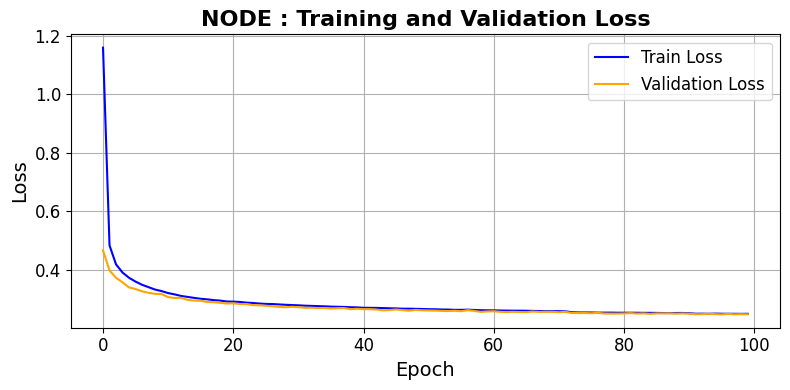

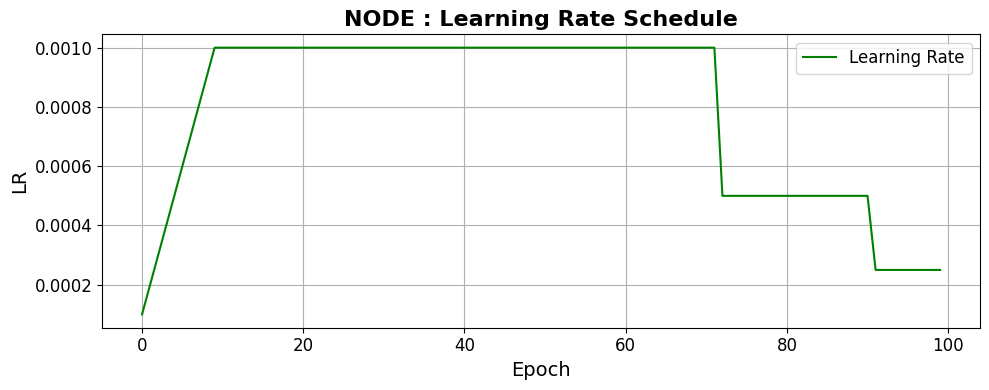

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

filename = "node_best.pth"
log_filename = "node_training_log.csv"

# Load your training log
df = pd.read_csv(f"check_points/{log_filename}")
# Inspect columns
print(df.head())
# Expected columns: ["epoch", "horizon", "train_loss", "val_loss", "lr"]

# Plot losses
plt.figure(figsize=(8,4))
plt.plot(df["epoch"], df["train_loss"], label="Train Loss", color="blue")
plt.plot(df["epoch"], df["val_loss"], label="Validation Loss", color="orange")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("NODE : Training and Validation Loss", fontweight='bold', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("check_points/node_loss_curve.png", dpi=300, bbox_inches="tight")
plt.show()

# Plot learning rate
plt.figure(figsize=(10,4))
plt.plot(df["epoch"], df["lr"], label="Learning Rate", color="green")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.title("NODE : Learning Rate Schedule", fontweight='bold', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("check_points/node_lr_curve.png", dpi=300, bbox_inches="tight")
plt.show()

In [18]:
# Load best checkpoint
problem = problem.to(device)
optimizer = optimizer = build_optimizer(problem)
scheduler_warmup, scheduler_plateau = build_schedulers(optimizer)

# Load best checkpoint if it exists
start_epoch, best_val_loss = load_best_checkpoint(
    problem, optimizer,
    filename,   # checkpoint file you saved during training
    device=device,
    scheduler=scheduler_plateau   # optional, if you want to restore scheduler state
)

🔄 Resumed from epoch 96, val_loss=0.2482, LR=0.000250


C:\Users\dutts\AppData\Local\Temp\ipykernel_118780\2458593391.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=device)


In [19]:
# --------------------------------------------------------------------
# TEST LOOP
# --------------------------------------------------------------------
# Load best model
def predict_with_best_model(problem, optimizer, test_loader,
                            filename, device=device):
    """
    Load best checkpoint and run predictions on test_loader.
    Returns concatenated arrays of y_true and y_pred.
    """
    start_epoch, best_val_loss, *_ = load_best_checkpoint(problem, optimizer, filename, device)

    problem.eval()
    predictions, targets = [], []

    with torch.no_grad():
        for batch in test_loader:
            batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v)
                     for k, v in batch.items()}
            outputs = problem(batch)
             # ✅ Both pred and true come from outputs
            y_pred = outputs["val_Ypred"][:, :outputs["val_Yref"].shape[1], :] .cpu().numpy()
            y_true = outputs["val_Yref"].cpu().numpy()
            predictions.append(y_pred)
            targets.append(y_true)

    y_pred = np.concatenate(predictions, axis=0)
    y_true = np.concatenate(targets, axis=0)
    return y_true, y_pred   # ✅ correct order

### Compare and Plot predicted and Actual trajectories from the test Set

In [20]:
from sklearn.metrics import root_mean_squared_error, r2_score
from scipy.stats import pearsonr

y_true, y_pred = predict_with_best_model(problem, optimizer, val_loader,
                                         filename="node_bestmodel.pth", device=device)

print("Shapes:", y_true.shape, y_pred.shape)

rmse = root_mean_squared_error(y_true.flatten(), y_pred.flatten())
r2 = r2_score(y_true.flatten(), y_pred.flatten())
corr, _ = pearsonr(y_true.flatten(), y_pred.flatten())

print(f"Test RMSE={rmse:.4f}, R²-Score={r2:.4f}, Correlation={corr:.4f}")

Shapes: (3301, 48, 1) (3301, 48, 1)
Test RMSE=0.2689, R²-Score=0.8247, Correlation=0.9086


NODE with no constraints:  
best checkpoint at epoch 100, val_loss=1.0662, LR=0.000500  
Test RMSE=0.4927, R²=0.6867, Correlation=0.8296

In [25]:
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

def plot_random_test_trajectories(y_true, y_pred, num_samples=6, save_path="check_points/node_test_trajs.png", seed=42):
    """
    Plot randomly selected true vs predicted trajectories from test set.
    Assumes y_true and y_pred are arrays of shape (N, T) where T = time steps.
    """
    random.seed(seed)
    n_samples = min(num_samples, y_true.shape[0])
    sampled_indices = random.sample(range(y_true.shape[0]), n_samples)

    ncols = min(3, n_samples)
    nrows = int(np.ceil(n_samples / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), squeeze=False)
    fig.suptitle("NODE : Observed vs Predicted Test Trajectories", fontsize=16, fontweight='bold')

    for i, idx in enumerate(sampled_indices):
        row, col = divmod(i, ncols)
        ax = axes[row][col]

        obs = y_true[idx]
        pred = y_pred[idx]
        t = np.arange(len(obs))

         # ✅ Flatten before metrics
        rmse = root_mean_squared_error(obs.flatten(), pred.flatten())
        r2 = r2_score(obs.flatten(), pred.flatten())
        corr, _ = pearsonr(obs.flatten(), pred.flatten())

        ax.plot(t, obs, label="Observed", lw=2)
        ax.plot(t, pred, label="Predicted", lw=2)
        ax.set_title(f"Sample {idx}\nRMSE={rmse:.2f}, R²={r2:.2f}, r={corr:.2f}")
        ax.set_xlabel("Time step")
        ax.set_ylabel("Value")
        ax.grid(True)
        ax.legend()

    # Hide unused subplots
    for j in range(i+1, nrows*ncols):
        row, col = divmod(j, ncols)
        fig.delaxes(axes[row][col])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

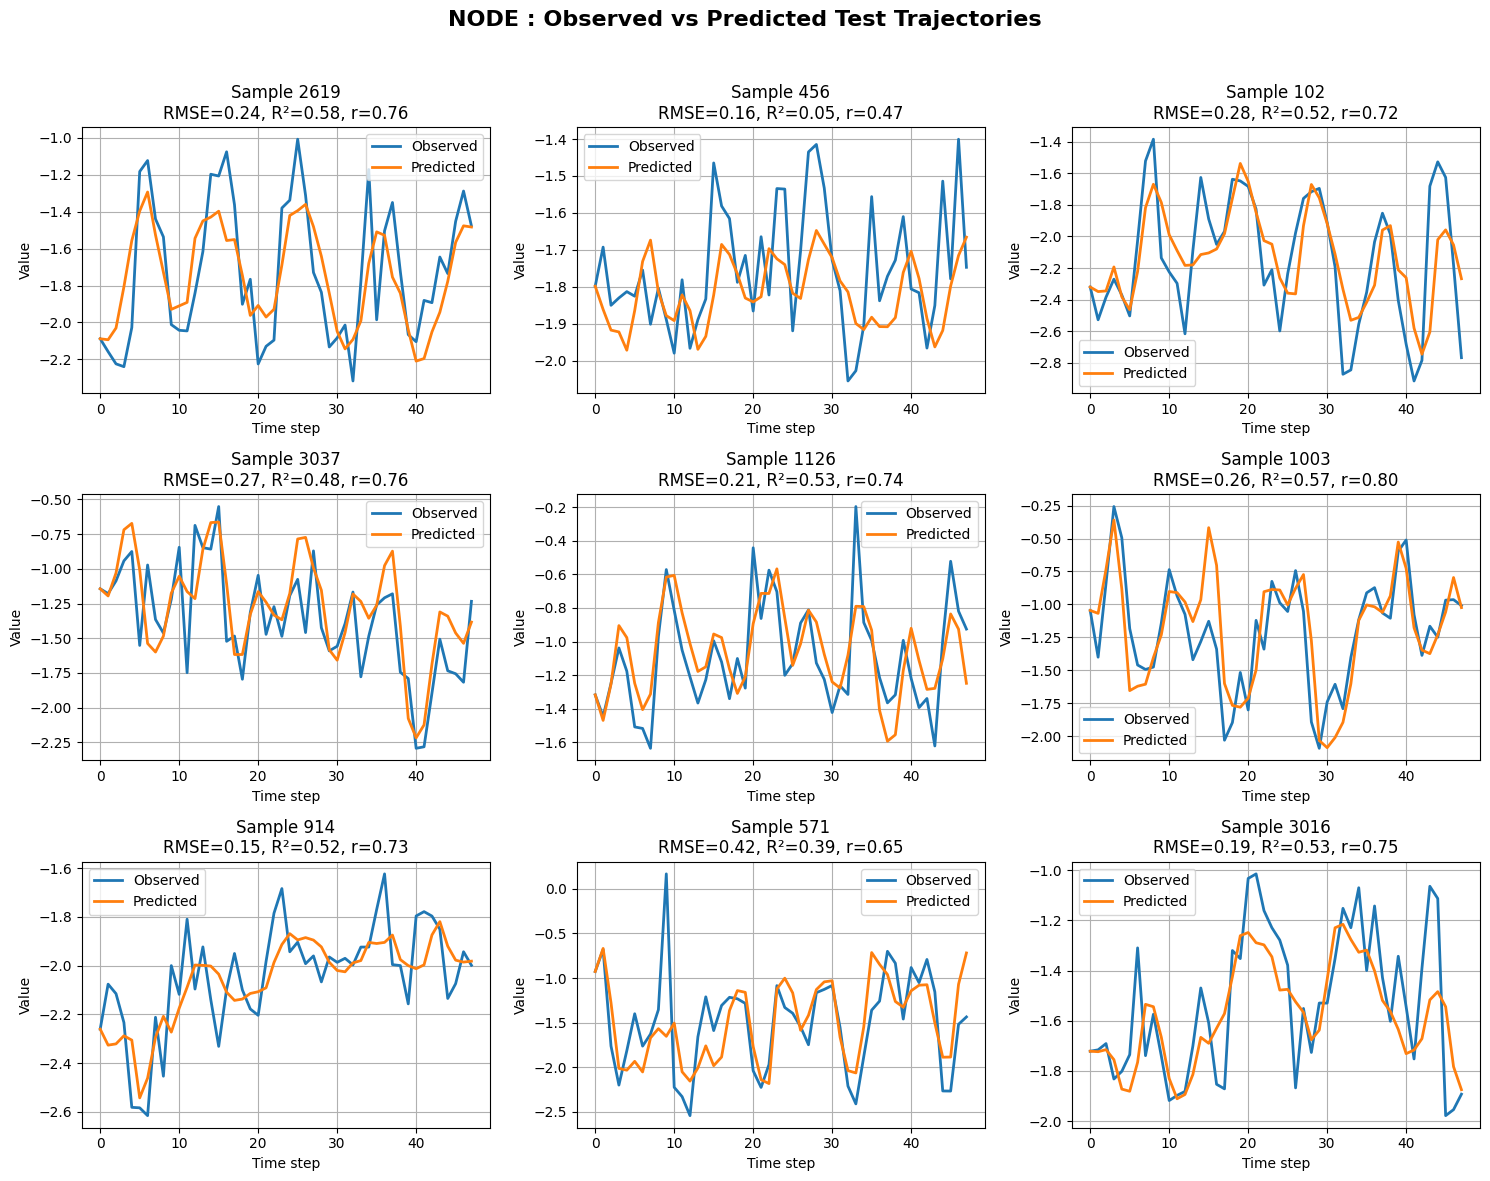

In [26]:
# After prediction
plot_random_test_trajectories(
    y_true,
    y_pred,
    save_path="check_points/node_test_trajs.png",
    num_samples=9
)

### Predictions on Training Data

In [29]:
def predict_with_best_model(problem, optimizer, train_loader,
                            filename="nodev1.0_bestmodel.pth", device="cpu"):
    """
    Load best checkpoint and run predictions on test_loader.
    Returns concatenated arrays of y_true and y_pred.
    """
    start_epoch, best_val_loss, *_ = load_best_checkpoint(problem, optimizer, filename, device)

    problem.eval()
    predictions, targets = [], []

    with torch.no_grad():
        for batch in train_loader:
            batch = {k: (v.to(device) if isinstance(v, torch.Tensor) else v)
                     for k, v in batch.items()}
            outputs = problem(batch)
             # ✅ Both pred and true come from outputs
            y_pred = outputs["train_Ypred"][:, :outputs["train_Yref"].shape[1], :] .cpu().numpy()
            y_true = outputs["train_Yref"].cpu().numpy()
            predictions.append(y_pred)
            targets.append(y_true)

    y_pred = np.concatenate(predictions, axis=0)
    y_true = np.concatenate(targets, axis=0)
    return y_true, y_pred   # ✅ correct order

In [30]:
y_true, y_pred = predict_with_best_model(problem, optimizer, train_loader,
                                         filename="nodev1.0_bestmodel.pth", device=device)

rmse = root_mean_squared_error(y_true.flatten(), y_pred.flatten())
r2 = r2_score(y_true.flatten(), y_pred.flatten())
corr, _ = pearsonr(y_true.flatten(), y_pred.flatten())

print(f"Test RMSE={rmse:.4f}, R²={r2:.4f}, Correlation={corr:.4f}")

🔄 Resumed from best checkpoint at epoch 58, val_loss=0.4409, LR=0.000008
Test RMSE=0.3373, R²=0.7343, Correlation=0.8569


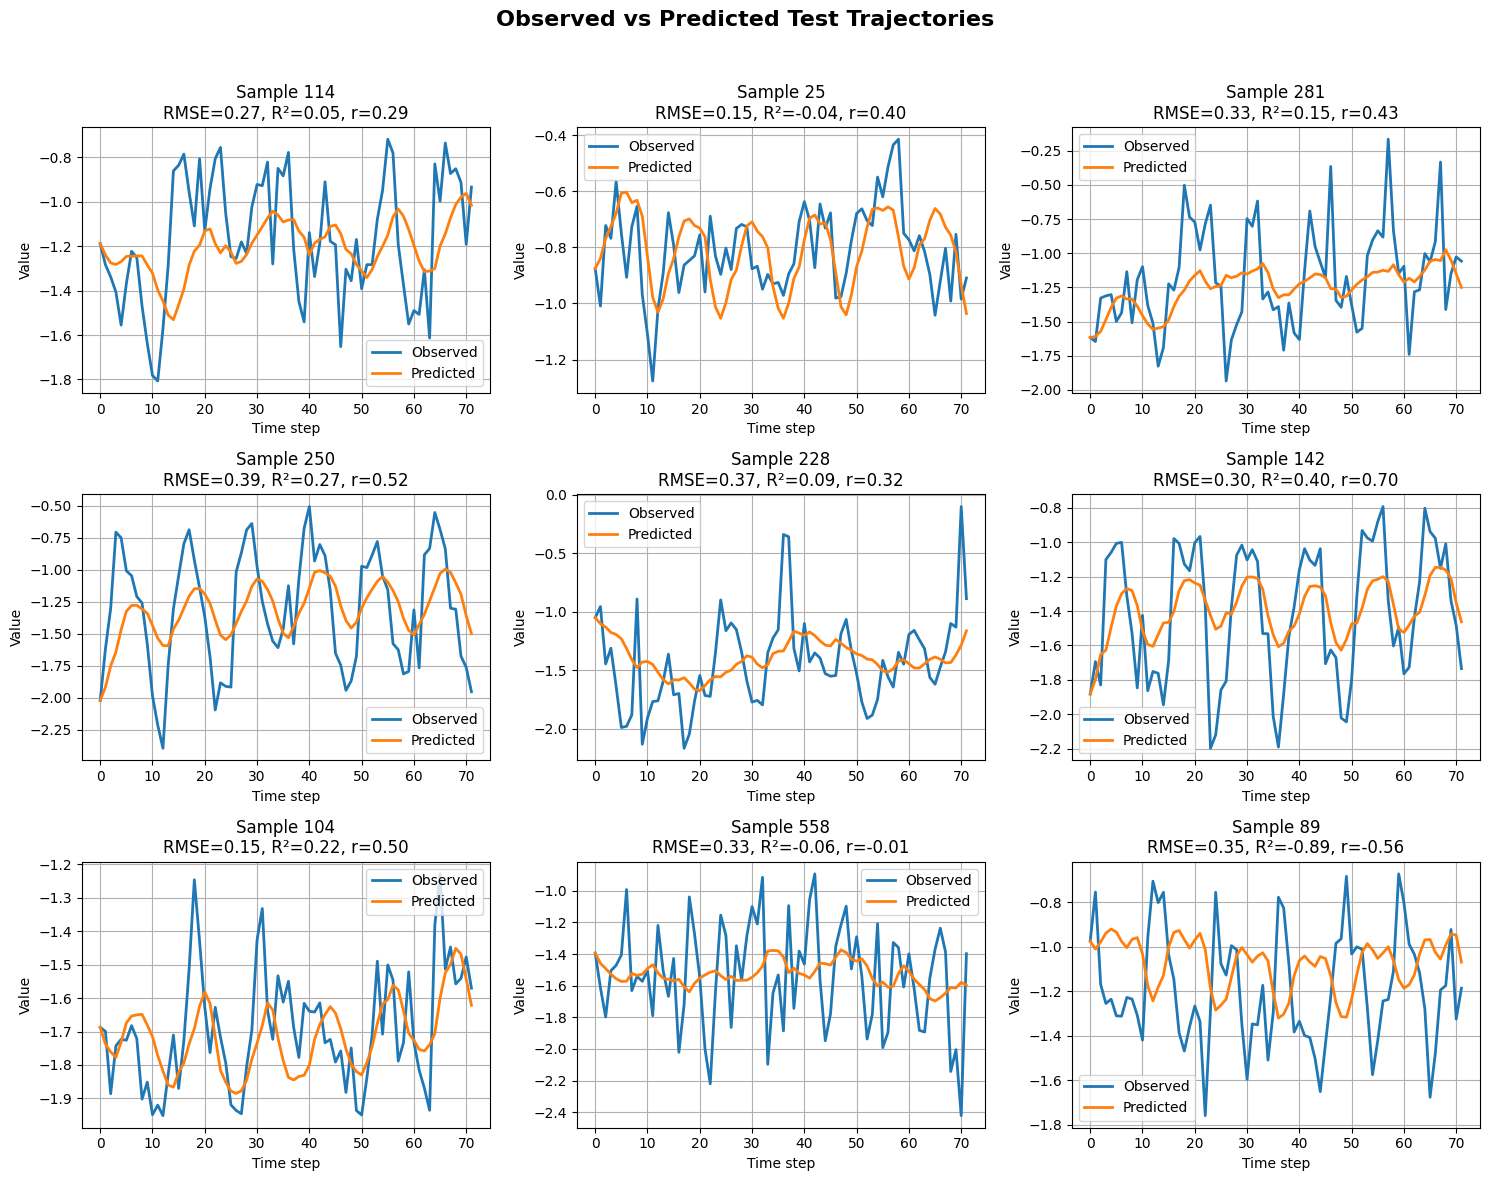

In [31]:
# After prediction
plot_random_test_trajectories(
    y_true,
    y_pred,
    save_path="check_points/nodev1.0_train_trajs_noconstraints_currtrg.png",
    num_samples=9
)